# Import Libraries and Data

In this part of the analysis, we are going to build time series models to see how well we can predict the typical home value in Nashville.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib.pylab import rcParams

In [2]:
ts_df = pd.read_csv("cleaned_data/model_data_clean.csv", index_col=0)

In [3]:
ts_df.head()

,id,host_id,zipcode,latitude,longitude,accommodates,bathrooms,beds,price,minimum_nights,...,property_type_Condominium,property_type_Guest suite,property_type_House,property_type_Other,property_type_Townhouse,room_type_Hotel room,room_type_Private room,room_type_Shared room,inventory,avg_home_value
2015-06-01,4.911123e+06,1.847859e+07,37202.099174,36.161913,-86.768430,4.223140,1.450413,2.033058,163.115702,1.545455,...,1.0,0.0,78.0,6.0,1.0,0.0,39.0,3.0,121,198388.0
2015-07-01,4.585624e+06,1.588542e+07,37202.203096,36.157222,-86.767316,4.607430,1.500310,2.308978,202.349226,1.698452,...,33.0,0.0,1049.0,59.0,18.0,0.0,451.0,18.0,1615,199865.0
2015-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,201227.0
2015-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,202952.0
2015-10-01,5.435875e+06,1.857827e+07,37201.418483,36.156564,-86.767390,4.795735,1.528910,2.406161,200.524171,1.747867,...,54.0,0.0,1370.0,72.0,51.0,0.0,566.0,30.0,2110,204617.0


# Set Time Series Index

In [4]:
ts_df.reset_index(inplace=True)
ts_df['index'] = pd.to_datetime(ts_df['index'],format='%Y/%m/%d')
ts_df.set_index('index', inplace=True)
ts_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69 entries, 2015-06-01 to 2021-02-01
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                39 non-null     float64
 1   host_id                           39 non-null     float64
 2   zipcode                           39 non-null     float64
 3   latitude                          39 non-null     float64
 4   longitude                         39 non-null     float64
 5   accommodates                      39 non-null     float64
 6   bathrooms                         39 non-null     float64
 7   beds                              39 non-null     float64
 8   price                             39 non-null     float64
 9   minimum_nights                    39 non-null     float64
 10  maximum_nights                    39 non-null     float64
 11  availability_30                   39 non-null     flo

# Deal with Missing Time Series Values

## Visualize the trend

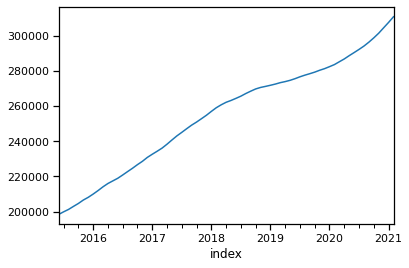

In [5]:
sns.set_context('notebook')
ts_df.avg_home_value.plot();

Appears to be trend without seasonality

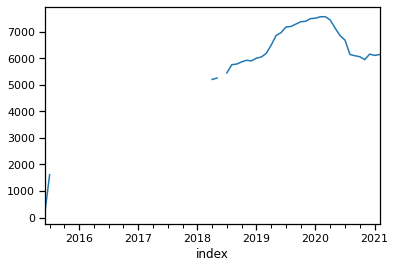

In [6]:
ts_df['inventory'] = ts_df['inventory'].replace(0,np.nan)
ts_df.inventory.plot();

Data appears to be missing throughout 2016 and 2017. Let's see what looking at just 2018 onward looks like.

## Focus on Dates after 2018

In [7]:
post_18_ts_df = ts_df['2018':]

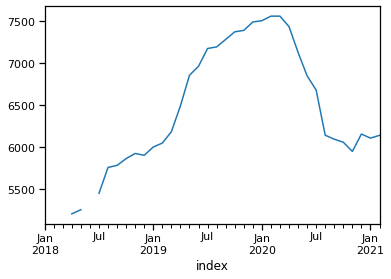

In [8]:
post_18_ts_df.inventory.plot();

There are still a handful of missing values. Let's use linear interpolation to fill in these values.

In [9]:
post_18_ts_df = post_18_ts_df.interpolate()

In [10]:
post_18_ts_df.dropna(inplace=True)

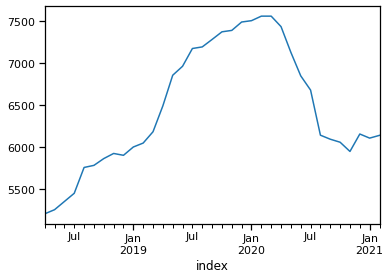

In [11]:
post_18_ts_df.inventory.plot();

## Interpolate Full Dataset

In [12]:
ts_df.interpolate(inplace=True)

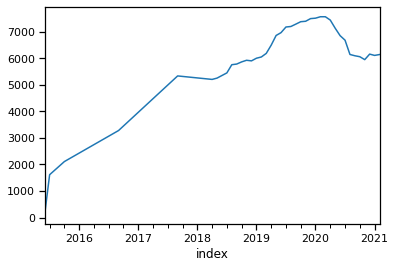

In [13]:
ts_df.inventory.plot();

# Explore Time Series

## Decompose Time Series

First, we will decompose the time series, assuming it is a series composed of adding the trend, seasonality and residual terms.

In [14]:
decomposition = seasonal_decompose(ts_df['avg_home_value'], model='add')

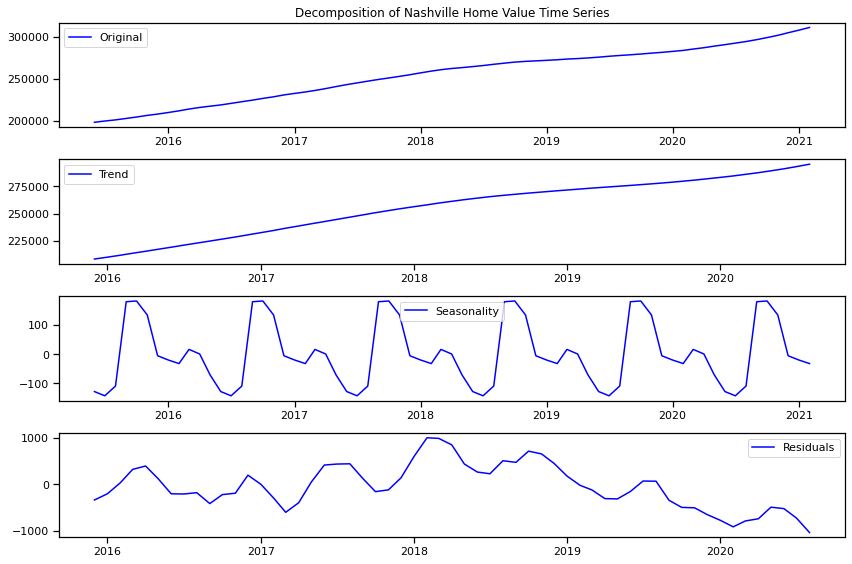

In [15]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot decompositions

plt.figure(figsize=(12,8))

plt.subplot(411)
plt.title('Decomposition of Nashville Home Value Time Series')
plt.plot(ts_df['avg_home_value'], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')

plt.tight_layout()

## Check Time Series stationarity

In [16]:
def stationarity_check(ts):
    roll_mean = ts.rolling(window=8, center=False).mean()
    roll_std = ts.rolling(window=8, center=False).std()
    fig = plt.figure(figsize=(8,5))
    plt.plot(ts, color='blue', label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    return dfoutput

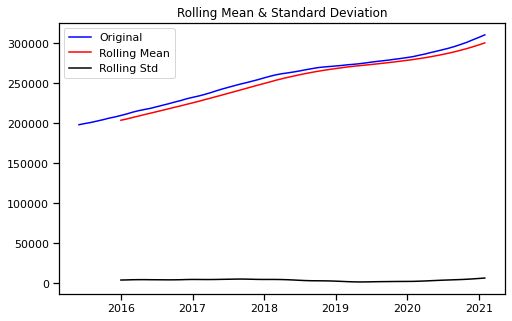

Test Statistic                  0.624229
p-value                         0.988198
#Lags Used                     10.000000
Number of Observations Used    58.000000
dtype: float64

In [17]:
ts = ts_df['avg_home_value']
stationarity_check(ts)

Because the p-value is much greater than 0.05, we cannot reject the null hypothesis that the data is not stationary. This makes sense based on what we've seen in the decomposition plots.

## Look at ACF and PACF plots

In order to examine the ACF and PACF plots, we need the data to be stationary first.

### Differencing

In [18]:
ts_diff = ts.diff(periods=1)
ts_diff.dropna(inplace=True)

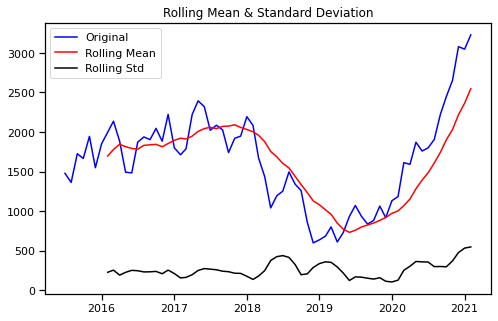

Test Statistic                 -3.483200
p-value                         0.008429
#Lags Used                     11.000000
Number of Observations Used    56.000000
dtype: float64

In [19]:
stationarity_check(ts_diff)

We can now reject the null hypothesis and confirm the data is stationary.

### Check ACF and PACF Plots

The ACF plot shows the correlation between the time series and its lagged values.

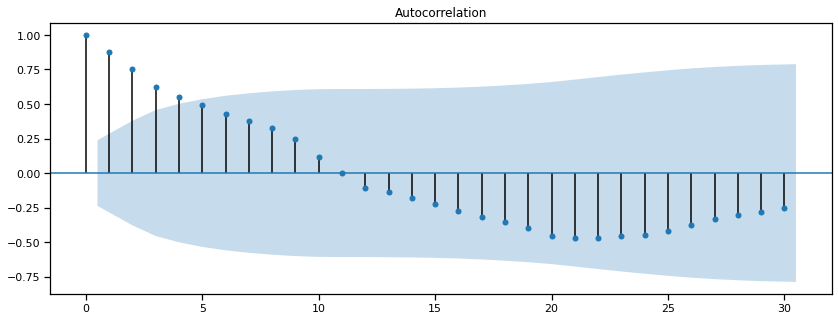

In [20]:
rcParams['figure.figsize'] = 14, 5

plot_acf(ts_diff, lags=30);

This ACF plot is gradually decreasing as lags increase.

The PACF plot shows the correlation between the time series and its own lagged values, with lags of intervening observations removed.

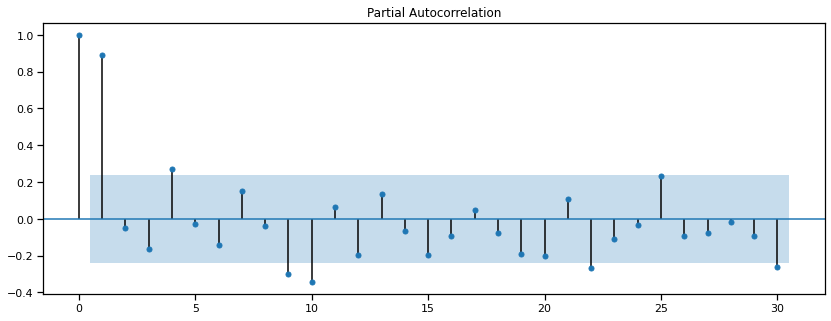

In [21]:
rcParams['figure.figsize'] = 14, 5

plot_pacf(ts_diff, lags=30);

The PACF plot has a sharp decrease after 2 lags.

This pattern of a gradually decreasing ACF plot and sharply decreasing PACF plot is characteristic of an AutoRegressive process.

Since the original time series is not stationary, we are going to run SARIMA and SARIMAX models, which do not require stationarity.

# SARIMA Time Series Model

## Set up Data for Modeling

In [22]:
home_values = ts_df['avg_home_value']

In [23]:
train_size = int(len(home_values)*.7)
test_size = int(len(home_values)-train_size)
train, test = home_values[0:train_size], home_values[train_size:len(home_values)]
print('Observations: %d' % (len(home_values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 69
Training Observations: 48
Testing Observations: 21


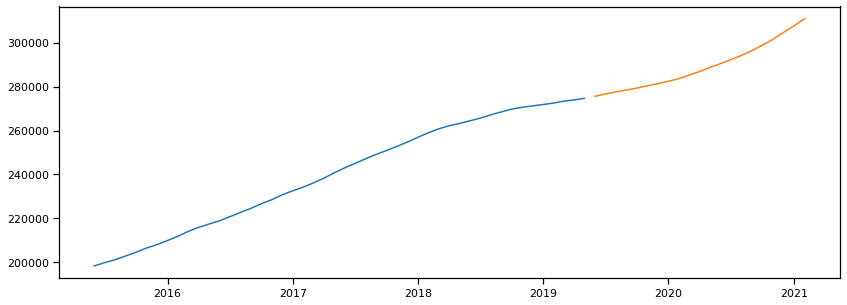

In [24]:
# view what time period the train and test set go through
plt.plot(train)
plt.plot(test)
plt.show()

## Parameter Selection for the SARIMA Model

We will use a for loop to test out every possible combination of p, d, and q values. We will choose the best model based on the Akaike information criterion (AIC) score, which can be used to determine relative model performance on the same dataset. AIC evaluates the fit on the data while also penalizing for overly complex models.

In [25]:
# set seasonal s equal to 12
s=12
# allow p, d and q to take any value from 0 to 1
p = d = q = range(0,2)

# generate all combinations of p,d and q
pdq = list(itertools.product(p, d, q))

# generate all combinations including seasonal combinations
pdqs = [(x[0], x[1], x[2], s) for x in pdq]

In [26]:
# run grid with parameters above and select best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        mod = SARIMAX(train,
                     order=comb,
                     seasonal_order=combs,
                     enforce_stationarity=False,
                     enforce_invertibility=False)
        output = mod.fit()
        ans.append([comb, combs, output.aic])
        print('ARIMA {} x {}12: AIC = {}'.format(comb, combs, output.aic))            

ARIMA (0, 0, 0) x (0, 0, 0, 12)12: AIC = 1300.8230609538462
ARIMA (0, 0, 0) x (0, 0, 1, 12)12: AIC = 1130.706083548577
ARIMA (0, 0, 0) x (0, 1, 0, 12)12: AIC = 798.9331500871451
ARIMA (0, 0, 0) x (0, 1, 1, 12)12: AIC = 524.02157038227
ARIMA (0, 0, 0) x (1, 0, 0, 12)12: AIC = 721.7873083191544
ARIMA (0, 0, 0) x (1, 0, 1, 12)12: AIC = 1039.0935159228868
ARIMA (0, 0, 0) x (1, 1, 0, 12)12: AIC = 483.98081615284605
ARIMA (0, 0, 0) x (1, 1, 1, 12)12: AIC = 437.52610372804617
ARIMA (0, 0, 1) x (0, 0, 0, 12)12: AIC = 41881.01203245639
ARIMA (0, 0, 1) x (0, 0, 1, 12)12: AIC = nan
ARIMA (0, 0, 1) x (0, 1, 0, 12)12: AIC = 758.615438262401
ARIMA (0, 0, 1) x (0, 1, 1, 12)12: AIC = 499.13524409318745
ARIMA (0, 0, 1) x (1, 0, 0, 12)12: AIC = 965.6123735074972
ARIMA (0, 0, 1) x (1, 0, 1, 12)12: AIC = nan
ARIMA (0, 0, 1) x (1, 1, 0, 12)12: AIC = 529.8899324443589
ARIMA (0, 0, 1) x (1, 1, 1, 12)12: AIC = 495.3898344439714
ARIMA (0, 1, 0) x (0, 0, 0, 12)12: AIC = 816.8576537210402
ARIMA (0, 1, 0) x (0, 0

In [27]:
ans_df = pd.DataFrame(ans, columns=['pdq','pdqs','aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           300.812
Name: 63, dtype: object

In [28]:
order = ans_df.loc[ans_df['aic'].idxmin()][0]
seasonal_order = ans_df.loc[ans_df['aic'].idxmin()][1]

## Fit SARIMA Model

In [29]:
SARIMA_MODEL = SARIMAX(train,
                      order=order,
                      seasonal_order=seasonal_order,
                      enforce_stationarity=False,
                      enforce_invertibility=False)

In [30]:
sarima_output = SARIMA_MODEL.fit()
sarima_output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     avg_home_value   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -145.406
Date:                            Wed, 14 Apr 2021   AIC                            300.812
Time:                                    09:21:03   BIC                            306.034
Sample:                                06-01-2015   HQIC                           301.945
                                     - 05-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9821      0.093     10.534      0.000       0.799       1.165
ma.L1          0.1519      0.216      0.705      0.481      -0.271       0.575
ar.S.L12      -0.6322      0.138     -4.582      0.000      -0.903      -0.362
ma.S.L12      -0.0055      0.054     -0.102      0.919      -0.112       0.101
sigma2      6.045e+04   3.08e+04      1.965      0.049     145.992    1.21e+05
===================================================================================
Ljung-Box (Q):                       28.00   Jarque-Bera (JB):                 1.68
Prob(Q):                              0.11   Prob(JB):                         0.43
Heteroskedasticity (H):               1.49   Skew:                            -0.35
Prob(H) (two-sided):                  0.61   Kurtosis:                         1.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

According to the p-values in our model summary, the moving average portion of the model is not statistically significant for non-seasonal or seasonal. We will try running a model with (1,1,0)(1,1,0,12) as our parameters and see if we get different results.

## SARIMA Model 2

In [31]:
SARIMA_MODEL2 = SARIMAX(train,
                      order=(1, 1, 0),
                      seasonal_order=(1, 1, 0, 12),
                      enforce_stationarity=False,
                      enforce_invertibility=False)

In [32]:
sarima_output_2 = SARIMA_MODEL2.fit()
sarima_output_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     avg_home_value   No. Observations:                   48
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -152.837
Date:                            Wed, 14 Apr 2021   AIC                            311.673
Time:                                    09:21:04   BIC                            314.947
Sample:                                06-01-2015   HQIC                           312.445
                                     - 05-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9900      0.083     11.907      0.000       0.827       1.153
ar.S.L12      -0.6094      0.134     -4.564      0.000      -0.871      -0.348
sigma2      6.335e+04   2.72e+04      2.331      0.020    1.01e+04    1.17e+05
===================================================================================
Ljung-Box (Q):                       28.08   Jarque-Bera (JB):                 1.87
Prob(Q):                              0.14   Prob(JB):                         0.39
Heteroskedasticity (H):               2.34   Skew:                            -0.34
Prob(H) (two-sided):                  0.29   Kurtosis:                         1.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Our AIC value is slightly higher in this model, therefore, we will stick with the original SARIMA model.

## Run Model Diagnostics

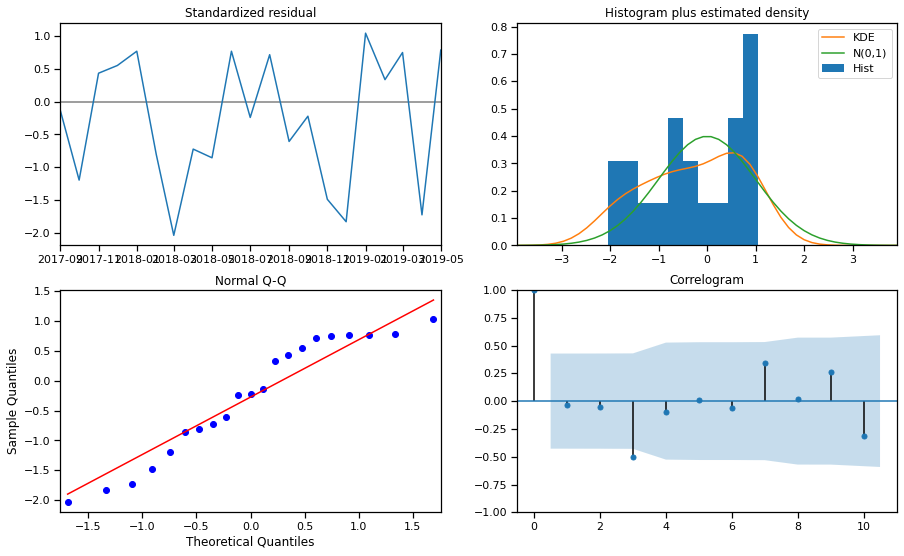

In [33]:
sarima_output.plot_diagnostics(figsize=(15,9));

It appears the residuals are normally distributed based on the KDE plot and the qq-plot, although there could be some violations at either tail.
The residuals appear to have white noise and are not showing signs of seasonality. The residuals are also not highly correlated with themselves based on the autocorrelation plot.

## One-Step Ahead Forecasting

In [34]:
pred = sarima_output.get_prediction(start=pd.to_datetime('2018-01-01'), 
                                      end=pd.to_datetime('2021-02-01'), 
                                    dynamic=False)
pred_conf = pred.conf_int()

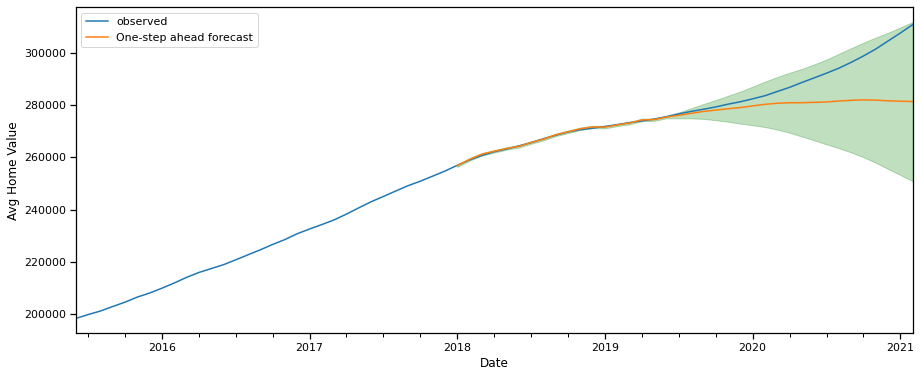

In [35]:
rcParams['figure.figsize'] = 15, 6

ax = home_values.plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast')

# plot confidence intervals
ax.fill_between(pred_conf.index,
               pred_conf.iloc[:,0],
               pred_conf.iloc[:,1], color='g', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Value')
plt.legend()
plt.show()

In [36]:
home_values_forecasted = pred.predicted_mean
home_values_true = home_values['2018':]
rmse = np.sqrt(((home_values_forecasted - home_values_true)**2).mean())
print(rmse)

9540.536091137623


The average error using a one-step ahead forecast is $9540, including the testing portion of the model.

## Dynamic Forecast

Dynamic forecasting uses values from previously forecasting time points to make predictions.

In [37]:
pred_dynamic = sarima_output.get_prediction(start=pd.to_datetime('2018-01-01'), 
                                            end=pd.to_datetime('2021-02-01'), 
                                            dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

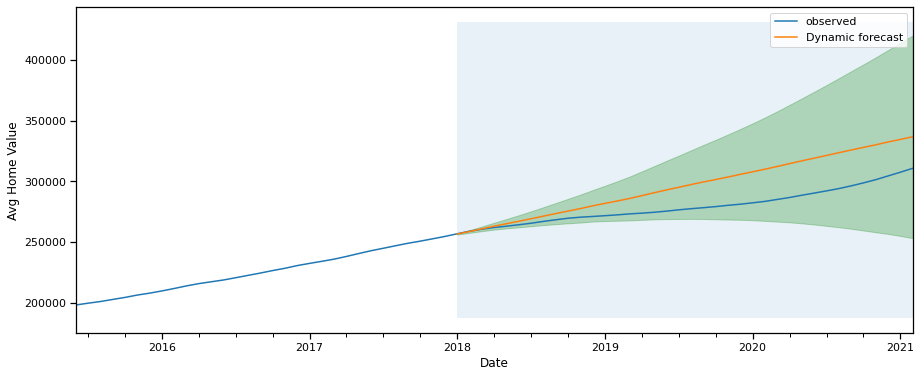

In [38]:
rcParams['figure.figsize'] = 15, 6

ax = home_values.plot(label='observed')

pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic forecast')

# plot confidence intervals
ax.fill_between(pred_dynamic_conf.index,
               pred_dynamic_conf.iloc[:,0],
               pred_dynamic_conf.iloc[:,1], color='g',alpha=0.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-01-01'), home_values_forecasted.index[-1], alpha=.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Value')
plt.legend()
plt.show()

In [39]:
dyn_home_values_forecasted = pred_dynamic.predicted_mean
home_values_true = home_values['2018':]
rmse = np.sqrt(((dyn_home_values_forecasted - home_values_true)**2).mean())
print(rmse)

19970.04381836502


Much higher RMSE using a dynamic model, and our predictions are higher than the actual values in this case.

## Predicting Future Values

In [40]:
forecast = sarima_output.get_prediction(start=pd.to_datetime('2018-01-01'), end=pd.to_datetime('2024-01-01'), 
                                     dynamic=True, full_results=True)
pred_conf = forecast.conf_int()

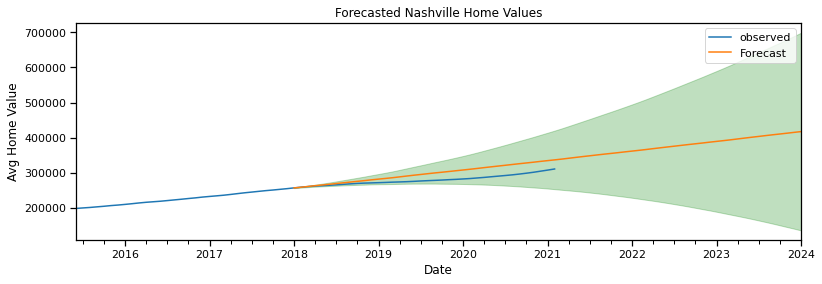

In [41]:
sns.set_context('notebook')
rcParams['figure.figsize'] = 13, 4
ax = home_values.plot(label='observed')
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
               pred_conf.iloc[:,0],
               pred_conf.iloc[:,1], color='G', alpha=.25)
ax.set_title('Forecasted Nashville Home Values')
ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Value')
plt.legend()
plt.show()

In [42]:
forecast.predicted_mean

2018-01-01    256782.647043
2018-02-01    258849.167517
2018-03-01    261035.271930
2018-04-01    263227.967106
2018-05-01    265250.383318
                  ...      
2023-09-01    408267.238434
2023-10-01    410454.845874
2023-11-01    412692.835181
2023-12-01    415064.538509
2024-01-01    417314.441867
Freq: MS, Length: 73, dtype: float64

In [43]:
forecast.predicted_mean['2023-06-01']

401241.20319533185

Our time series forecast predicts the average home value to break the $400k threshold in June 2023.

# SARIMAX Time Series Model

## Parameter Selection for SARIMAX Model

For our exogenous parameters in our SARIMAX model, we will use the most important features selected from our regression model.

In [44]:
final_reg_df = pd.read_csv("cleaned_data/final_reg_features.csv", index_col=0)

features = list(final_reg_df.columns)

final_time_series_df = ts_df[features]
post_18_final_time_series_df = post_18_ts_df[features]

final_time_series_df

,avg_home_value,beds,number_of_reviews,price
index,,,,
2015-06-01,198388.0,2.033058,17.206612,163.115702
2015-07-01,199865.0,2.308978,16.536223,202.349226
2015-08-01,201227.0,2.341373,16.929362,201.740874
2015-09-01,202952.0,2.373767,17.322501,201.132522
2015-10-01,204617.0,2.406161,17.715640,200.524171
...,...,...,...,...
2020-10-01,298809.0,3.715442,53.884558,212.609249
2020-11-01,301461.0,3.692683,54.217325,211.482086
2020-12-01,304539.0,3.645701,53.611572,212.335529


In [45]:
home_values = final_time_series_df['avg_home_value']
exog = final_time_series_df.drop('avg_home_value', axis=1)

In [46]:
train_size = int(len(home_values)*.7)
train, test = home_values[0:train_size], home_values[train_size:len(home_values)]
train_exog, test_exog = exog[0:train_size], exog[train_size:len(home_values)]
print('Observations: %d' % (len(home_values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 69
Training Observations: 48
Testing Observations: 21


In [47]:
# run for loop again to find best parameters for SARIMAX model
ans = []
for comb in pdq:
    for combs in pdqs:
        mod = SARIMAX(train, train_exog,
                     order=comb,
                     seasonal_order=combs,
                     enforce_stationarity=False,
                     enforce_invertibility=False)
        output = mod.fit()
        ans.append([comb, combs, output.aic])
        print('ARIMA {} x {}12: AIC = {}'.format(comb, combs, output.aic))         

ARIMA (0, 0, 0) x (0, 0, 0, 12)12: AIC = 877.5395540503977
ARIMA (0, 0, 0) x (0, 0, 1, 12)12: AIC = 1351.1082944928603
ARIMA (0, 0, 0) x (0, 1, 0, 12)12: AIC = 680.844988056415
ARIMA (0, 0, 0) x (0, 1, 1, 12)12: AIC = 453.91287514290474
ARIMA (0, 0, 0) x (1, 0, 0, 12)12: AIC = 682.3403517411007
ARIMA (0, 0, 0) x (1, 0, 1, 12)12: AIC = 1452.9607172728665
ARIMA (0, 0, 0) x (1, 1, 0, 12)12: AIC = 449.5924697111756
ARIMA (0, 0, 0) x (1, 1, 1, 12)12: AIC = 441.3729220586709
ARIMA (0, 0, 1) x (0, 0, 0, 12)12: AIC = 842.5055000758593
ARIMA (0, 0, 1) x (0, 0, 1, 12)12: AIC = 2778.162619300422
ARIMA (0, 0, 1) x (0, 1, 0, 12)12: AIC = 647.8925366365341
ARIMA (0, 0, 1) x (0, 1, 1, 12)12: AIC = 422.77180861501654
ARIMA (0, 0, 1) x (1, 0, 0, 12)12: AIC = 671.1137963008841
ARIMA (0, 0, 1) x (1, 0, 1, 12)12: AIC = 11043.225656513043
ARIMA (0, 0, 1) x (1, 1, 0, 12)12: AIC = 461.40459947309307
ARIMA (0, 0, 1) x (1, 1, 1, 12)12: AIC = 420.11207051601826
ARIMA (0, 1, 0) x (0, 0, 0, 12)12: AIC = 762.55651

In [48]:
ans_df = pd.DataFrame(ans, columns=['pdq','pdqs','aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           323.153
Name: 63, dtype: object

In [49]:
order = ans_df.loc[ans_df['aic'].idxmin()][0]
seasonal_order = ans_df.loc[ans_df['aic'].idxmin()][1]

## Fit SARIMAX Model

In [50]:
SARIMAX_MODEL = SARIMAX(train, train_exog,
                      order=order,
                      seasonal_order=seasonal_order,
                      enforce_stationarity=False,
                      enforce_invertibility=False)

In [51]:
sarimax_output = SARIMAX_MODEL.fit()
sarimax_output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     avg_home_value   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -153.577
Date:                            Wed, 14 Apr 2021   AIC                            323.153
Time:                                    09:21:26   BIC                            331.510
Sample:                                06-01-2015   HQIC                           324.967
                                     - 05-01-2019                                         
Covariance Type:                              opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
beds               4484.5250   3394.747      1.321      0.186   -2169.058    1.11e+04
number_of_reviews  -206.4967    571.346     -0.361      0.718   -1326.314     913.320
price               -11.3600     56.750     -0.200      0.841    -122.588      99.868
ar.L1                 0.8760      0.447      1.962      0.050       0.001       1.751
ma.L1                 0.0846      0.608      0.139      0.889      -1.107       1.276
ar.S.L12             -0.7390      0.776     -0.953      0.341      -2.259       0.781
ma.S.L12              0.0019      0.038      0.050      0.960      -0.072       0.076
sigma2             2.171e+05   1.25e+05      1.742      0.082   -2.72e+04    4.61e+05
===================================================================================
Ljung-Box (Q):                       16.05   Jarque-Bera (JB):                14.55
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               3.98   Skew:                            -1.34
Prob(H) (two-sided):                  0.09   Kurtosis:                         6.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The AIC value for the SARIMAX model is slightly higher than the SARIMA model, and our exogenous factors do not have significant p-values.

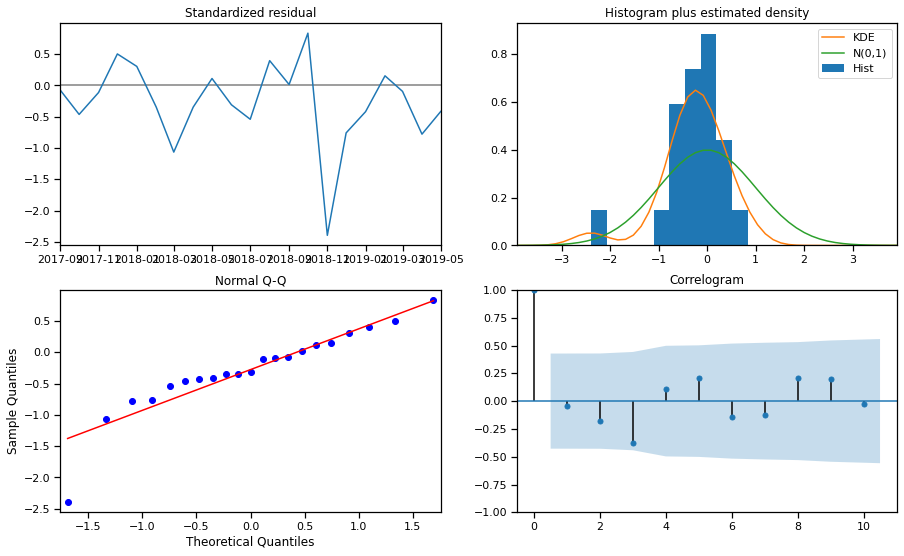

In [52]:
sarimax_output.plot_diagnostics(figsize=(15,9));

## Make Predictions

In [53]:
pred = sarimax_output.get_prediction(start=pd.to_datetime('2018-01-01'), end=pd.to_datetime('2021-02-01'), dynamic=False,
                            exog=test_exog)
pred_conf = pred.conf_int()

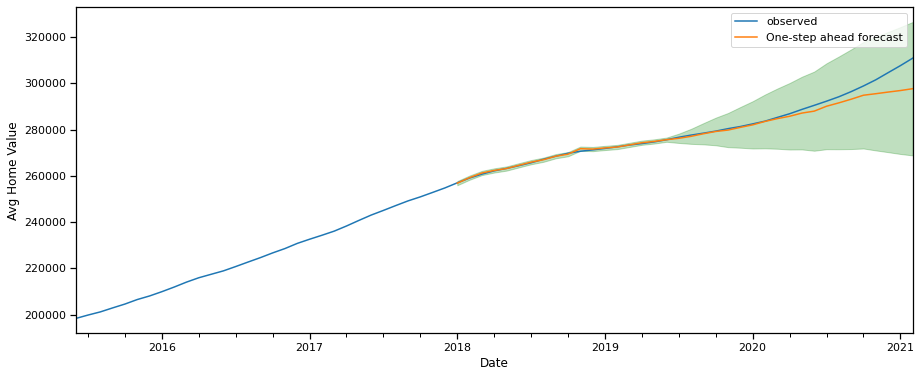

In [54]:
rcParams['figure.figsize'] = 15, 6

ax = home_values.plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast')

# plot confidence intervals
ax.fill_between(pred_conf.index,
               pred_conf.iloc[:,0],
               pred_conf.iloc[:,1], color='g', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Value')
plt.legend()
plt.show()

In [55]:
home_values_forecasted = pred.predicted_mean
home_values_true = home_values['2018':]
rmse = np.sqrt(((home_values_forecasted - home_values_true)**2).mean())
print(rmse)

3432.6316774663796


The SARIMAX model has slightly better results than the SARIMA model from a one-step ahead forecasting perspective.

## Dynamic Forecast

In [56]:
pred_dynamic = sarimax_output.get_prediction(start=pd.to_datetime('2018-01-01'), end=pd.to_datetime('2021-02-01'),
                                     dynamic=True, full_results=True, exog=test_exog)
pred_dynamic_conf = pred_dynamic.conf_int()

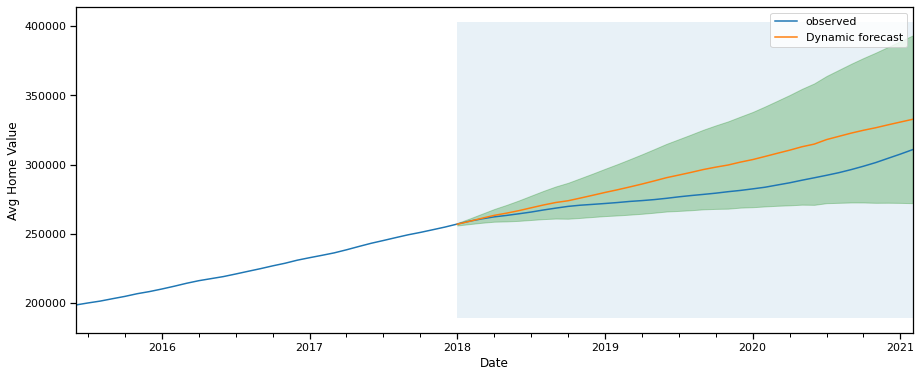

In [57]:
rcParams['figure.figsize'] = 15, 6

ax = home_values.plot(label='observed')

pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic forecast')

# plot confidence intervals
ax.fill_between(pred_dynamic_conf.index,
               pred_dynamic_conf.iloc[:,0],
               pred_dynamic_conf.iloc[:,1], color='g',alpha=0.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-01-01'), home_values_forecasted.index[-1], alpha=.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Value')
plt.legend()
plt.show()

In [58]:
dyn_home_values_forecasted = pred_dynamic.predicted_mean
home_values_true = home_values['2018':]
rmse = np.sqrt(((dyn_home_values_forecasted - home_values_true)**2).mean())
print(rmse)

17107.99029991148


The SARIMAX model performed slightly better than the SARIMA model from an RMSE perspective. However, since we don't have future values for our exogenous features, we will use the SARIMA model to predict future average home values.